# Pokemon Classifier - Transfer Learning (EfficientNetB0)

Classification de 151 Pokémon avec Transfer Learning.

**Stratégie**: Feature Extraction (30 epochs) puis Fine-Tuning (80 epochs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

TensorFlow: 2.16.2
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Chargement des données

In [2]:
data_path = Path('./PokemonData')
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}

pokemon_dirs = sorted([d for d in data_path.iterdir() if d.is_dir()])
image_paths, labels = [], []

for pokemon_dir in pokemon_dirs:
    for img in pokemon_dir.iterdir():
        if img.suffix.lower() in image_extensions:
            image_paths.append(str(img))
            labels.append(pokemon_dir.name)

image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Images: {len(image_paths)} | Classes: {len(np.unique(labels))}")

Images: 32471 | Classes: 151


## Split Train/Val/Test

In [3]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

print(f"Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")

Train: 25976 | Val: 3247 | Test: 3248


## Préparation des données

In [4]:
unique_labels = sorted(np.unique(train_labels))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
num_classes = len(unique_labels)

train_labels_onehot = tf.keras.utils.to_categorical([label_to_idx[l] for l in train_labels], num_classes)
val_labels_onehot = tf.keras.utils.to_categorical([label_to_idx[l] for l in val_labels], num_classes)
test_labels_onehot = tf.keras.utils.to_categorical([label_to_idx[l] for l in test_labels], num_classes)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (256, 256))
    return img, label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15),
    layers.RandomBrightness(0.15),
])

def augment_and_preprocess(img, label):
    img = data_augmentation(img, training=True)
    return preprocess_input(img), label

def preprocess_only(img, label):
    return preprocess_input(img), label

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_dataset = (tf.data.Dataset.from_tensor_slices((train_paths, train_labels_onehot))
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(1000).batch(batch_size).prefetch(AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((val_paths, val_labels_onehot))
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .map(preprocess_only, num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE))

test_dataset = (tf.data.Dataset.from_tensor_slices((test_paths, test_labels_onehot))
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .map(preprocess_only, num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE))

print("Datasets prêts avec preprocess_input EfficientNet")

2025-12-05 08:13:23.767585: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-05 08:13:23.767627: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-05 08:13:23.767631: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-12-05 08:13:23.767671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-05 08:13:23.767681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Datasets prêts avec preprocess_input EfficientNet


## Architecture Transfer Learning

Fine tuning du modèle EfficientNetB0 (classification sur 1000 classes)

In [5]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
print(f"\nBase model: {base_model.count_params():,} params (frozen)")
print(f"Trainable: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 151)            │        38,807 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,883,770 (18.63 MB)

 Trainable params: 830,103 (3.17 MB)

 Non-trainable params: 4,053,667 (15.46 MB)


Base model: 4,049,571 params (frozen)
Trainable: 830,103


## Phase 1: Feature Extraction (30 epochs)

In [6]:
print("PHASE 1: Feature Extraction")
print("Base model FROZEN | LR: 1e-3 | Epochs: 30")

callbacks_p1 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

history_p1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks_p1
)

print(f"\nPhase 1 terminée - Best val acc: {max(history_p1.history['val_accuracy']):.4f}")

PHASE 1: Feature Extraction
Base model FROZEN | LR: 1e-3 | Epochs: 30
Epoch 1/30


2025-12-05 08:13:27.015402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


298/812 ━━━━━━━━━━━━━━━━━━━━ 1:22 161ms/step - accuracy: 0.0635 - loss: 5.1193

2025-12-05 08:14:23.110581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 34s 163ms/step - accuracy: 0.1178 - loss: 4.5862

2025-12-05 08:15:12.396731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.1434 - loss: 4.3668

2025-12-05 08:15:41.626926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 159s 184ms/step - accuracy: 0.2574 - loss: 3.4482 - val_accuracy: 0.6175 - val_loss: 1.6067 - learning_rate: 0.0010
Epoch 2/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:25 166ms/step - accuracy: 0.4418 - loss: 2.3685

2025-12-05 08:16:55.967577: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - accuracy: 0.4463 - loss: 2.3208

2025-12-05 08:17:43.288118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.4488 - loss: 2.3001

2025-12-05 08:18:11.133717: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 146s 177ms/step - accuracy: 0.4614 - loss: 2.2088 - val_accuracy: 0.6994 - val_loss: 1.2880 - learning_rate: 0.0010
Epoch 3/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:21 159ms/step - accuracy: 0.4988 - loss: 2.0168

2025-12-05 08:19:19.142655: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 33s 156ms/step - accuracy: 0.5052 - loss: 2.0005

2025-12-05 08:20:04.967943: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.5076 - loss: 1.9950

2025-12-05 08:20:32.252974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - accuracy: 0.5172 - loss: 1.9725 - val_accuracy: 0.7133 - val_loss: 1.1589 - learning_rate: 0.0010
Epoch 4/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:24 165ms/step - accuracy: 0.5475 - loss: 1.8466

2025-12-05 08:21:42.613923: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - accuracy: 0.5455 - loss: 1.8500

2025-12-05 08:22:28.593699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.5452 - loss: 1.8505

2025-12-05 08:22:56.394908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 143s 174ms/step - accuracy: 0.5441 - loss: 1.8505 - val_accuracy: 0.7210 - val_loss: 1.1002 - learning_rate: 0.0010
Epoch 5/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:23 162ms/step - accuracy: 0.5641 - loss: 1.7621

2025-12-05 08:24:04.883140: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.5602 - loss: 1.7672

2025-12-05 08:24:51.602486: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.5601 - loss: 1.7683

2025-12-05 08:25:19.894201: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 143s 174ms/step - accuracy: 0.5602 - loss: 1.7714 - val_accuracy: 0.7382 - val_loss: 1.0673 - learning_rate: 0.0010
Epoch 6/30
296/812 ━━━━━━━━━━━━━━━━━━━━ 1:21 157ms/step - accuracy: 0.5787 - loss: 1.7160

2025-12-05 08:26:26.325237: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - accuracy: 0.5762 - loss: 1.7214

2025-12-05 08:27:14.565028: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


771/812 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.5757 - loss: 1.7223

2025-12-05 08:27:42.058773: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - accuracy: 0.5735 - loss: 1.7244 - val_accuracy: 0.7376 - val_loss: 1.0478 - learning_rate: 0.0010
Epoch 7/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:17 151ms/step - accuracy: 0.5901 - loss: 1.6545

2025-12-05 08:28:46.945832: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - accuracy: 0.5886 - loss: 1.6583

2025-12-05 08:29:32.297166: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.5876 - loss: 1.6616

2025-12-05 08:29:59.294396: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 137s 167ms/step - accuracy: 0.5818 - loss: 1.6811 - val_accuracy: 0.7453 - val_loss: 1.0151 - learning_rate: 0.0010
Epoch 8/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:23 163ms/step - accuracy: 0.5907 - loss: 1.6338

2025-12-05 08:31:07.826997: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 33s 156ms/step - accuracy: 0.5922 - loss: 1.6361

2025-12-05 08:31:52.580744: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.5919 - loss: 1.6409

2025-12-05 08:32:18.454699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 139s 170ms/step - accuracy: 0.5897 - loss: 1.6603 - val_accuracy: 0.7555 - val_loss: 1.0036 - learning_rate: 0.0010
Epoch 9/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:18 152ms/step - accuracy: 0.5937 - loss: 1.6547

2025-12-05 08:33:23.801077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.5957 - loss: 1.6376

2025-12-05 08:34:08.212193: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.5958 - loss: 1.6364

2025-12-05 08:34:35.246223: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 137s 167ms/step - accuracy: 0.5961 - loss: 1.6290 - val_accuracy: 0.7530 - val_loss: 0.9918 - learning_rate: 0.0010
Epoch 10/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:21 158ms/step - accuracy: 0.6028 - loss: 1.5623

2025-12-05 08:35:42.637936: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - accuracy: 0.6039 - loss: 1.5725

2025-12-05 08:36:26.114288: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.6030 - loss: 1.5798

2025-12-05 08:36:51.978599: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 135s 165ms/step - accuracy: 0.5988 - loss: 1.6080 - val_accuracy: 0.7558 - val_loss: 0.9820 - learning_rate: 0.0010
Epoch 11/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:16 148ms/step - accuracy: 0.5996 - loss: 1.6115

2025-12-05 08:37:54.821318: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step - accuracy: 0.6024 - loss: 1.6023

2025-12-05 08:38:39.310696: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.6027 - loss: 1.6022

2025-12-05 08:39:05.580844: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 133s 163ms/step - accuracy: 0.6047 - loss: 1.6018 - val_accuracy: 0.7629 - val_loss: 0.9736 - learning_rate: 0.0010
Epoch 12/30
296/812 ━━━━━━━━━━━━━━━━━━━━ 1:15 146ms/step - accuracy: 0.6091 - loss: 1.5685

2025-12-05 08:40:07.198081: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 31s 147ms/step - accuracy: 0.6091 - loss: 1.5767

2025-12-05 08:40:51.537045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


771/812 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6088 - loss: 1.5810

2025-12-05 08:41:17.978407: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 134s 163ms/step - accuracy: 0.6061 - loss: 1.6008 - val_accuracy: 0.7589 - val_loss: 0.9682 - learning_rate: 0.0010
Epoch 13/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:18 154ms/step - accuracy: 0.6228 - loss: 1.5435

2025-12-05 08:42:23.842998: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.6177 - loss: 1.5476

2025-12-05 08:43:09.706642: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.6159 - loss: 1.5519

2025-12-05 08:43:36.622174: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - accuracy: 0.6098 - loss: 1.5678 - val_accuracy: 0.7567 - val_loss: 0.9520 - learning_rate: 0.0010
Epoch 14/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:18 152ms/step - accuracy: 0.6135 - loss: 1.5512

2025-12-05 08:44:41.579839: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.6143 - loss: 1.5439

2025-12-05 08:45:27.615811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.6143 - loss: 1.5435

2025-12-05 08:45:53.083417: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 136s 166ms/step - accuracy: 0.6145 - loss: 1.5423 - val_accuracy: 0.7626 - val_loss: 0.9371 - learning_rate: 0.0010
Epoch 15/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:18 154ms/step - accuracy: 0.6102 - loss: 1.5540

2025-12-05 08:46:58.361556: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.6122 - loss: 1.5426

2025-12-05 08:47:43.843478: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.6132 - loss: 1.5412

2025-12-05 08:48:10.266489: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - accuracy: 0.6165 - loss: 1.5372 - val_accuracy: 0.7718 - val_loss: 0.9339 - learning_rate: 0.0010
Epoch 16/30
296/812 ━━━━━━━━━━━━━━━━━━━━ 1:13 143ms/step - accuracy: 0.6178 - loss: 1.5433

2025-12-05 08:49:12.872537: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.6180 - loss: 1.5346

2025-12-05 08:49:55.294716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


771/812 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.6184 - loss: 1.5334

2025-12-05 08:50:20.642823: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 130s 159ms/step - accuracy: 0.6186 - loss: 1.5304 - val_accuracy: 0.7681 - val_loss: 0.9272 - learning_rate: 0.0010
Epoch 17/30
296/812 ━━━━━━━━━━━━━━━━━━━━ 1:18 153ms/step - accuracy: 0.6335 - loss: 1.4646

2025-12-05 08:51:25.851277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


595/812 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - accuracy: 0.6301 - loss: 1.4751

2025-12-05 08:52:10.512003: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


771/812 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.6282 - loss: 1.4821

2025-12-05 08:52:36.858313: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 133s 162ms/step - accuracy: 0.6212 - loss: 1.5140 - val_accuracy: 0.7724 - val_loss: 0.9150 - learning_rate: 0.0010
Epoch 18/30
296/812 ━━━━━━━━━━━━━━━━━━━━ 1:08 132ms/step - accuracy: 0.6250 - loss: 1.5001

2025-12-05 08:53:32.617303: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step - accuracy: 0.6238 - loss: 1.5035

2025-12-05 08:54:12.189759: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


771/812 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.6231 - loss: 1.5067

2025-12-05 08:54:38.958710: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 128s 156ms/step - accuracy: 0.6213 - loss: 1.5162 - val_accuracy: 0.7616 - val_loss: 0.9240 - learning_rate: 0.0010
Epoch 19/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:32 179ms/step - accuracy: 0.6204 - loss: 1.5083

2025-12-05 08:55:54.511488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6231 - loss: 1.5034

2025-12-05 08:56:49.424560: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.6236 - loss: 1.5048

2025-12-05 08:57:21.344304: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 163s 199ms/step - accuracy: 0.6245 - loss: 1.5112 - val_accuracy: 0.7678 - val_loss: 0.9157 - learning_rate: 0.0010
Epoch 20/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:24 164ms/step - accuracy: 0.6321 - loss: 1.4850

2025-12-05 08:58:33.401701: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 35s 166ms/step - accuracy: 0.6292 - loss: 1.4847

2025-12-05 08:59:23.632910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.6284 - loss: 1.4850

2025-12-05 08:59:54.926267: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 156s 190ms/step - accuracy: 0.6250 - loss: 1.4890 - val_accuracy: 0.7666 - val_loss: 0.9094 - learning_rate: 0.0010
Epoch 21/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:24 165ms/step - accuracy: 0.6371 - loss: 1.4342

2025-12-05 09:01:09.367832: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 33s 155ms/step - accuracy: 0.6324 - loss: 1.4562

2025-12-05 09:01:52.830551: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6311 - loss: 1.4632

2025-12-05 09:02:19.175376: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 137s 167ms/step - accuracy: 0.6278 - loss: 1.4874 - val_accuracy: 0.7764 - val_loss: 0.9056 - learning_rate: 0.0010
Epoch 22/30
296/812 ━━━━━━━━━━━━━━━━━━━━ 1:15 146ms/step - accuracy: 0.6341 - loss: 1.4750

2025-12-05 09:03:20.501494: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - accuracy: 0.6344 - loss: 1.4721

2025-12-05 09:04:05.963070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


771/812 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.6335 - loss: 1.4758

2025-12-05 09:04:32.297756: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 134s 163ms/step - accuracy: 0.6287 - loss: 1.4907 - val_accuracy: 0.7727 - val_loss: 0.9048 - learning_rate: 0.0010
Epoch 23/30
296/812 ━━━━━━━━━━━━━━━━━━━━ 1:17 150ms/step - accuracy: 0.6406 - loss: 1.4377

2025-12-05 09:05:35.876643: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - accuracy: 0.6377 - loss: 1.4485

2025-12-05 09:06:20.024617: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


771/812 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.6368 - loss: 1.4530

2025-12-05 09:06:47.576458: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 136s 166ms/step - accuracy: 0.6333 - loss: 1.4685 - val_accuracy: 0.7733 - val_loss: 0.9031 - learning_rate: 0.0010
Epoch 24/30
296/812 ━━━━━━━━━━━━━━━━━━━━ 1:16 149ms/step - accuracy: 0.6464 - loss: 1.4425

2025-12-05 09:07:51.374986: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 31s 147ms/step - accuracy: 0.6420 - loss: 1.4468

2025-12-05 09:08:34.954899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


771/812 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.6402 - loss: 1.4494

2025-12-05 09:08:59.689725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 134s 164ms/step - accuracy: 0.6346 - loss: 1.4587 - val_accuracy: 0.7749 - val_loss: 0.9051 - learning_rate: 0.0010
Epoch 25/30
296/812 ━━━━━━━━━━━━━━━━━━━━ 1:29 173ms/step - accuracy: 0.6288 - loss: 1.4691

2025-12-05 09:10:12.808119: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 38s 176ms/step - accuracy: 0.6302 - loss: 1.4615

2025-12-05 09:11:06.779294: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


771/812 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.6307 - loss: 1.4606

2025-12-05 09:11:36.984362: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 156s 191ms/step - accuracy: 0.6335 - loss: 1.4595 - val_accuracy: 0.7749 - val_loss: 0.9040 - learning_rate: 0.0010
Epoch 26/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:22 161ms/step - accuracy: 0.6369 - loss: 1.4585

2025-12-05 09:12:46.188825: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 36s 168ms/step - accuracy: 0.6376 - loss: 1.4475

2025-12-05 09:13:38.714053: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.6375 - loss: 1.4467

2025-12-05 09:14:08.548343: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 153s 187ms/step - accuracy: 0.6360 - loss: 1.4490 - val_accuracy: 0.7776 - val_loss: 0.8929 - learning_rate: 0.0010
Epoch 27/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:29 174ms/step - accuracy: 0.6355 - loss: 1.4635

2025-12-05 09:15:23.338822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - accuracy: 0.6366 - loss: 1.4522

2025-12-05 09:16:22.648009: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.6364 - loss: 1.4520

2025-12-05 09:16:55.255528: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 163s 199ms/step - accuracy: 0.6367 - loss: 1.4500 - val_accuracy: 0.7816 - val_loss: 0.8856 - learning_rate: 0.0010
Epoch 28/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:16 149ms/step - accuracy: 0.6398 - loss: 1.4183

2025-12-05 09:17:58.892942: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step - accuracy: 0.6419 - loss: 1.4145

2025-12-05 09:18:43.100860: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6419 - loss: 1.4168

2025-12-05 09:19:08.666458: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 133s 161ms/step - accuracy: 0.6415 - loss: 1.4276 - val_accuracy: 0.7835 - val_loss: 0.8788 - learning_rate: 0.0010
Epoch 29/30
296/812 ━━━━━━━━━━━━━━━━━━━━ 1:16 149ms/step - accuracy: 0.6407 - loss: 1.4224

2025-12-05 09:20:10.802144: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step - accuracy: 0.6404 - loss: 1.4223

2025-12-05 09:20:56.880344: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


771/812 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.6403 - loss: 1.4237

2025-12-05 09:21:24.287265: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 137s 167ms/step - accuracy: 0.6392 - loss: 1.4285 - val_accuracy: 0.7872 - val_loss: 0.8711 - learning_rate: 0.0010
Epoch 30/30
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:16 149ms/step - accuracy: 0.6427 - loss: 1.4241

2025-12-05 09:22:28.713673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 31s 147ms/step - accuracy: 0.6422 - loss: 1.4257

2025-12-05 09:23:12.409727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.6418 - loss: 1.4293

2025-12-05 09:23:37.988810: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 133s 162ms/step - accuracy: 0.6384 - loss: 1.4481 - val_accuracy: 0.7847 - val_loss: 0.8832 - learning_rate: 0.0010

Phase 1 terminée - Best val acc: 0.7872


## Phase 2: Fine-Tuning (80 epochs)

In [7]:
print("PHASE 2: Fine-Tuning")

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

trainable = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"30 dernières couches dégelées | LR: 1e-5 | Epochs: 80")
print(f"Paramètres trainables: {trainable:,}")

callbacks_p2 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

history_p2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=80,
    callbacks=callbacks_p2
)

print(f"\nPhase 2 terminée - Best val acc: {max(history_p2.history['val_accuracy']):.4f}")

PHASE 2: Fine-Tuning
30 dernières couches dégelées | LR: 1e-5 | Epochs: 80
Paramètres trainables: 2,326,263
Epoch 1/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:45 206ms/step - accuracy: 0.5777 - loss: 1.7439

2025-12-05 09:25:08.540756: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.5800 - loss: 1.7058

2025-12-05 09:26:09.289036: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.5822 - loss: 1.6898

2025-12-05 09:26:44.608732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 191s 222ms/step - accuracy: 0.5957 - loss: 1.6115 - val_accuracy: 0.7656 - val_loss: 0.9268 - learning_rate: 1.0000e-05
Epoch 2/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:49 213ms/step - accuracy: 0.6108 - loss: 1.5109

2025-12-05 09:28:12.677384: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 45s 210ms/step - accuracy: 0.6161 - loss: 1.4889

2025-12-05 09:29:14.861902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.6179 - loss: 1.4828

2025-12-05 09:29:57.891802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 196s 240ms/step - accuracy: 0.6292 - loss: 1.4445 - val_accuracy: 0.7853 - val_loss: 0.8534 - learning_rate: 1.0000e-05
Epoch 3/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 2:15 264ms/step - accuracy: 0.6407 - loss: 1.4075

2025-12-05 09:31:44.370491: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 55s 259ms/step - accuracy: 0.6437 - loss: 1.3864

2025-12-05 09:33:00.174330: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.6446 - loss: 1.3798 

2025-12-05 09:33:39.115970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 216s 264ms/step - accuracy: 0.6502 - loss: 1.3468 - val_accuracy: 0.7933 - val_loss: 0.8084 - learning_rate: 1.0000e-05
Epoch 4/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:54 224ms/step - accuracy: 0.6629 - loss: 1.2950

2025-12-05 09:35:08.051940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 50s 235ms/step - accuracy: 0.6663 - loss: 1.2845

2025-12-05 09:36:21.567117: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.6678 - loss: 1.2813

2025-12-05 09:37:01.727467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 202s 247ms/step - accuracy: 0.6735 - loss: 1.2652 - val_accuracy: 0.8035 - val_loss: 0.7739 - learning_rate: 1.0000e-05
Epoch 5/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 2:02 238ms/step - accuracy: 0.6735 - loss: 1.2490

2025-12-05 09:38:35.400670: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 49s 231ms/step - accuracy: 0.6767 - loss: 1.2391

2025-12-05 09:39:42.448181: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.6782 - loss: 1.2345

2025-12-05 09:40:24.820501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 205s 249ms/step - accuracy: 0.6848 - loss: 1.2159 - val_accuracy: 0.8103 - val_loss: 0.7487 - learning_rate: 1.0000e-05
Epoch 6/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 2:01 236ms/step - accuracy: 0.6788 - loss: 1.2176

2025-12-05 09:41:58.645327: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 50s 234ms/step - accuracy: 0.6833 - loss: 1.2048

2025-12-05 09:43:08.010601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.6851 - loss: 1.2006

2025-12-05 09:43:46.052550: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 200s 244ms/step - accuracy: 0.6921 - loss: 1.1803 - val_accuracy: 0.8174 - val_loss: 0.7257 - learning_rate: 1.0000e-05
Epoch 7/80
299/812 ━━━━━━━━━━━━━━━━━━━━ 1:48 212ms/step - accuracy: 0.7000 - loss: 1.1342

2025-12-05 09:45:11.850109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.7005 - loss: 1.1304

2025-12-05 09:46:17.171898: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


774/812 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.7009 - loss: 1.1311

2025-12-05 09:46:56.144482: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 190s 231ms/step - accuracy: 0.7027 - loss: 1.1346 - val_accuracy: 0.8204 - val_loss: 0.7071 - learning_rate: 1.0000e-05
Epoch 8/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:51 217ms/step - accuracy: 0.7073 - loss: 1.1041

2025-12-05 09:48:22.496695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 47s 221ms/step - accuracy: 0.7082 - loss: 1.1021

2025-12-05 09:49:29.693001: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.7090 - loss: 1.1021

2025-12-05 09:50:13.192515: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 197s 241ms/step - accuracy: 0.7124 - loss: 1.0991 - val_accuracy: 0.8226 - val_loss: 0.6896 - learning_rate: 1.0000e-05
Epoch 9/80
299/812 ━━━━━━━━━━━━━━━━━━━━ 2:00 236ms/step - accuracy: 0.7216 - loss: 1.0736

2025-12-05 09:51:45.658563: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 49s 232ms/step - accuracy: 0.7199 - loss: 1.0717

2025-12-05 09:52:53.745125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


774/812 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.7193 - loss: 1.0722

2025-12-05 09:53:31.908626: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 199s 243ms/step - accuracy: 0.7190 - loss: 1.0695 - val_accuracy: 0.8257 - val_loss: 0.6751 - learning_rate: 1.0000e-05
Epoch 10/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:57 228ms/step - accuracy: 0.7254 - loss: 1.0694

2025-12-05 09:55:02.020587: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 49s 230ms/step - accuracy: 0.7256 - loss: 1.0610

2025-12-05 09:56:11.213657: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.7257 - loss: 1.0585

2025-12-05 09:56:50.168529: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 197s 241ms/step - accuracy: 0.7264 - loss: 1.0503 - val_accuracy: 0.8281 - val_loss: 0.6625 - learning_rate: 1.0000e-05
Epoch 11/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:42 199ms/step - accuracy: 0.7232 - loss: 1.0369

2025-12-05 09:58:10.967536: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.7247 - loss: 1.0336

2025-12-05 09:59:13.556250: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.7249 - loss: 1.0346

2025-12-05 09:59:48.929288: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 178s 217ms/step - accuracy: 0.7273 - loss: 1.0364 - val_accuracy: 0.8331 - val_loss: 0.6506 - learning_rate: 1.0000e-05
Epoch 12/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:43 202ms/step - accuracy: 0.7260 - loss: 1.0339

2025-12-05 10:01:09.403506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 43s 203ms/step - accuracy: 0.7301 - loss: 1.0195

2025-12-05 10:02:10.104775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.7314 - loss: 1.0165

2025-12-05 10:02:45.776201: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 177s 217ms/step - accuracy: 0.7355 - loss: 1.0096 - val_accuracy: 0.8352 - val_loss: 0.6396 - learning_rate: 1.0000e-05
Epoch 13/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:46 207ms/step - accuracy: 0.7361 - loss: 1.0100

2025-12-05 10:04:08.189219: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.7381 - loss: 1.0033

2025-12-05 10:05:08.855185: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.7383 - loss: 1.0006

2025-12-05 10:05:44.425001: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 178s 217ms/step - accuracy: 0.7384 - loss: 0.9890 - val_accuracy: 0.8383 - val_loss: 0.6300 - learning_rate: 1.0000e-05
Epoch 14/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:43 201ms/step - accuracy: 0.7399 - loss: 0.9756

2025-12-05 10:07:04.510378: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 44s 206ms/step - accuracy: 0.7409 - loss: 0.9707

2025-12-05 10:08:07.441806: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.7420 - loss: 0.9683

2025-12-05 10:08:43.499830: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 179s 219ms/step - accuracy: 0.7472 - loss: 0.9571 - val_accuracy: 0.8423 - val_loss: 0.6221 - learning_rate: 1.0000e-05
Epoch 15/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:48 212ms/step - accuracy: 0.7479 - loss: 0.9418

2025-12-05 10:10:06.457220: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 45s 210ms/step - accuracy: 0.7489 - loss: 0.9417

2025-12-05 10:11:08.758130: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.7491 - loss: 0.9432

2025-12-05 10:11:45.662635: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 182s 222ms/step - accuracy: 0.7499 - loss: 0.9486 - val_accuracy: 0.8429 - val_loss: 0.6140 - learning_rate: 1.0000e-05
Epoch 16/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:52 219ms/step - accuracy: 0.7378 - loss: 0.9666

2025-12-05 10:13:10.490090: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 50s 232ms/step - accuracy: 0.7402 - loss: 0.9591

2025-12-05 10:14:23.716191: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.7413 - loss: 0.9577

2025-12-05 10:15:07.602392: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 208s 254ms/step - accuracy: 0.7470 - loss: 0.9477 - val_accuracy: 0.8460 - val_loss: 0.6030 - learning_rate: 1.0000e-05
Epoch 17/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 2:09 252ms/step - accuracy: 0.7502 - loss: 0.9385

2025-12-05 10:16:48.383935: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 54s 252ms/step - accuracy: 0.7520 - loss: 0.9331

2025-12-05 10:18:03.541455: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.7524 - loss: 0.9325

2025-12-05 10:18:46.194781: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 220s 270ms/step - accuracy: 0.7550 - loss: 0.9276 - val_accuracy: 0.8488 - val_loss: 0.5951 - learning_rate: 1.0000e-05
Epoch 18/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 2:07 248ms/step - accuracy: 0.7452 - loss: 0.9385

2025-12-05 10:20:27.437101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 53s 246ms/step - accuracy: 0.7488 - loss: 0.9329

2025-12-05 10:21:40.064578: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7499 - loss: 0.9311 

2025-12-05 10:22:22.120975: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 215s 262ms/step - accuracy: 0.7557 - loss: 0.9198 - val_accuracy: 0.8506 - val_loss: 0.5885 - learning_rate: 1.0000e-05
Epoch 19/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 2:09 252ms/step - accuracy: 0.7632 - loss: 0.9117

2025-12-05 10:24:03.417169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.7627 - loss: 0.9063

2025-12-05 10:24:56.802057: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.7624 - loss: 0.9058

2025-12-05 10:25:31.730677: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 184s 224ms/step - accuracy: 0.7617 - loss: 0.9019 - val_accuracy: 0.8525 - val_loss: 0.5811 - learning_rate: 1.0000e-05
Epoch 20/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:46 208ms/step - accuracy: 0.7589 - loss: 0.8989

2025-12-05 10:26:53.677906: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.7602 - loss: 0.8975

2025-12-05 10:27:53.480510: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.7601 - loss: 0.8982

2025-12-05 10:28:28.409741: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 178s 218ms/step - accuracy: 0.7599 - loss: 0.8976 - val_accuracy: 0.8531 - val_loss: 0.5753 - learning_rate: 1.0000e-05
Epoch 21/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:47 209ms/step - accuracy: 0.7583 - loss: 0.8889

2025-12-05 10:29:52.199788: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 45s 211ms/step - accuracy: 0.7616 - loss: 0.8797

2025-12-05 10:30:55.649496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.7625 - loss: 0.8800

2025-12-05 10:31:30.847548: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 181s 222ms/step - accuracy: 0.7661 - loss: 0.8821 - val_accuracy: 0.8562 - val_loss: 0.5698 - learning_rate: 1.0000e-05
Epoch 22/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:42 198ms/step - accuracy: 0.7678 - loss: 0.8660

2025-12-05 10:32:50.403422: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.7677 - loss: 0.8665

2025-12-05 10:33:51.972329: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.7680 - loss: 0.8657

2025-12-05 10:34:27.035074: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 175s 214ms/step - accuracy: 0.7695 - loss: 0.8626 - val_accuracy: 0.8565 - val_loss: 0.5644 - learning_rate: 1.0000e-05
Epoch 23/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:44 204ms/step - accuracy: 0.7649 - loss: 0.8554

2025-12-05 10:35:47.611209: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - accuracy: 0.7676 - loss: 0.8565

2025-12-05 10:36:46.258403: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.7690 - loss: 0.8549

2025-12-05 10:37:21.272060: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 175s 214ms/step - accuracy: 0.7745 - loss: 0.8490 - val_accuracy: 0.8586 - val_loss: 0.5585 - learning_rate: 1.0000e-05
Epoch 24/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:42 199ms/step - accuracy: 0.7602 - loss: 0.8664

2025-12-05 10:38:41.171089: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.7666 - loss: 0.8572

2025-12-05 10:39:44.012829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.7676 - loss: 0.8562

2025-12-05 10:40:18.492150: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 178s 218ms/step - accuracy: 0.7729 - loss: 0.8475 - val_accuracy: 0.8614 - val_loss: 0.5515 - learning_rate: 1.0000e-05
Epoch 25/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:52 218ms/step - accuracy: 0.7710 - loss: 0.8605

2025-12-05 10:41:45.036352: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 44s 209ms/step - accuracy: 0.7727 - loss: 0.8530

2025-12-05 10:42:45.017999: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.7734 - loss: 0.8510

2025-12-05 10:43:19.369382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 180s 220ms/step - accuracy: 0.7769 - loss: 0.8401 - val_accuracy: 0.8617 - val_loss: 0.5462 - learning_rate: 1.0000e-05
Epoch 26/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:44 204ms/step - accuracy: 0.7784 - loss: 0.8540

2025-12-05 10:44:41.137388: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 43s 201ms/step - accuracy: 0.7797 - loss: 0.8436

2025-12-05 10:45:40.272049: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.7799 - loss: 0.8412

2025-12-05 10:46:15.118618: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 175s 213ms/step - accuracy: 0.7810 - loss: 0.8274 - val_accuracy: 0.8623 - val_loss: 0.5409 - learning_rate: 1.0000e-05
Epoch 27/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:42 199ms/step - accuracy: 0.7731 - loss: 0.8421

2025-12-05 10:47:34.254187: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 42s 198ms/step - accuracy: 0.7759 - loss: 0.8338

2025-12-05 10:48:33.106492: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.7762 - loss: 0.8327

2025-12-05 10:49:08.343977: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 174s 212ms/step - accuracy: 0.7797 - loss: 0.8265 - val_accuracy: 0.8645 - val_loss: 0.5381 - learning_rate: 1.0000e-05
Epoch 28/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:47 209ms/step - accuracy: 0.7859 - loss: 0.8118

2025-12-05 10:50:30.951305: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 45s 211ms/step - accuracy: 0.7860 - loss: 0.8055

2025-12-05 10:51:34.438210: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.7856 - loss: 0.8058

2025-12-05 10:52:12.707866: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 186s 227ms/step - accuracy: 0.7830 - loss: 0.8088 - val_accuracy: 0.8654 - val_loss: 0.5324 - learning_rate: 1.0000e-05
Epoch 29/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:57 228ms/step - accuracy: 0.7797 - loss: 0.8293

2025-12-05 10:53:42.331393: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 48s 226ms/step - accuracy: 0.7846 - loss: 0.8148

2025-12-05 10:54:49.285753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.7853 - loss: 0.8129

2025-12-05 10:55:28.943168: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 197s 241ms/step - accuracy: 0.7877 - loss: 0.8045 - val_accuracy: 0.8670 - val_loss: 0.5286 - learning_rate: 1.0000e-05
Epoch 30/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:54 222ms/step - accuracy: 0.7925 - loss: 0.7702

2025-12-05 10:56:57.899319: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.7924 - loss: 0.7745

2025-12-05 10:57:59.872555: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.7919 - loss: 0.7776

2025-12-05 10:58:39.746217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 191s 233ms/step - accuracy: 0.7915 - loss: 0.7878 - val_accuracy: 0.8676 - val_loss: 0.5236 - learning_rate: 1.0000e-05
Epoch 31/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:47 208ms/step - accuracy: 0.7849 - loss: 0.7921

2025-12-05 11:00:04.538749: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.7870 - loss: 0.7862

2025-12-05 11:01:03.314334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.7878 - loss: 0.7850

2025-12-05 11:01:37.922466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 176s 214ms/step - accuracy: 0.7899 - loss: 0.7833 - val_accuracy: 0.8688 - val_loss: 0.5191 - learning_rate: 1.0000e-05
Epoch 32/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:40 196ms/step - accuracy: 0.7937 - loss: 0.7873

2025-12-05 11:02:56.388940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - accuracy: 0.7939 - loss: 0.7779

2025-12-05 11:03:54.815027: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.7939 - loss: 0.7775

2025-12-05 11:04:29.332026: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 173s 211ms/step - accuracy: 0.7944 - loss: 0.7734 - val_accuracy: 0.8685 - val_loss: 0.5159 - learning_rate: 1.0000e-05
Epoch 33/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:42 199ms/step - accuracy: 0.7973 - loss: 0.7667

2025-12-05 11:05:50.095589: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 42s 198ms/step - accuracy: 0.7971 - loss: 0.7637

2025-12-05 11:06:49.082463: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.7970 - loss: 0.7631

2025-12-05 11:07:23.473689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 172s 211ms/step - accuracy: 0.7963 - loss: 0.7625 - val_accuracy: 0.8703 - val_loss: 0.5107 - learning_rate: 1.0000e-05
Epoch 34/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:41 198ms/step - accuracy: 0.7852 - loss: 0.7915

2025-12-05 11:08:42.331109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 42s 198ms/step - accuracy: 0.7886 - loss: 0.7814

2025-12-05 11:09:41.198141: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.7894 - loss: 0.7790

2025-12-05 11:10:15.578671: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 172s 211ms/step - accuracy: 0.7922 - loss: 0.7700 - val_accuracy: 0.8719 - val_loss: 0.5069 - learning_rate: 1.0000e-05
Epoch 35/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:43 202ms/step - accuracy: 0.7994 - loss: 0.7560

2025-12-05 11:11:35.852710: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 43s 201ms/step - accuracy: 0.7996 - loss: 0.7495

2025-12-05 11:12:35.393275: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.7996 - loss: 0.7496

2025-12-05 11:13:09.978832: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 174s 213ms/step - accuracy: 0.8009 - loss: 0.7488 - val_accuracy: 0.8725 - val_loss: 0.5031 - learning_rate: 1.0000e-05
Epoch 36/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:37 190ms/step - accuracy: 0.7966 - loss: 0.7675

2025-12-05 11:14:26.550974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 38s 179ms/step - accuracy: 0.7984 - loss: 0.7600

2025-12-05 11:15:16.790294: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.7989 - loss: 0.7585

2025-12-05 11:15:46.254753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 153s 187ms/step - accuracy: 0.8005 - loss: 0.7539 - val_accuracy: 0.8722 - val_loss: 0.4992 - learning_rate: 1.0000e-05
Epoch 37/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:26 168ms/step - accuracy: 0.7983 - loss: 0.7361

2025-12-05 11:16:53.200650: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 36s 168ms/step - accuracy: 0.7995 - loss: 0.7364

2025-12-05 11:17:43.771717: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.7998 - loss: 0.7364

2025-12-05 11:18:13.401089: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 147s 179ms/step - accuracy: 0.8015 - loss: 0.7349 - val_accuracy: 0.8747 - val_loss: 0.4958 - learning_rate: 1.0000e-05
Epoch 38/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:26 167ms/step - accuracy: 0.8029 - loss: 0.7240

2025-12-05 11:19:19.950940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 35s 167ms/step - accuracy: 0.8040 - loss: 0.7302

2025-12-05 11:20:10.109719: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.8040 - loss: 0.7329

2025-12-05 11:20:39.543424: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 146s 178ms/step - accuracy: 0.8043 - loss: 0.7401 - val_accuracy: 0.8740 - val_loss: 0.4934 - learning_rate: 1.0000e-05
Epoch 39/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:26 168ms/step - accuracy: 0.8017 - loss: 0.7238

2025-12-05 11:21:46.218926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 36s 168ms/step - accuracy: 0.8030 - loss: 0.7228

2025-12-05 11:22:36.582377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.8034 - loss: 0.7236

2025-12-05 11:23:05.823282: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 147s 179ms/step - accuracy: 0.8045 - loss: 0.7270 - val_accuracy: 0.8753 - val_loss: 0.4902 - learning_rate: 1.0000e-05
Epoch 40/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:25 167ms/step - accuracy: 0.8117 - loss: 0.7091

2025-12-05 11:24:12.388284: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 35s 167ms/step - accuracy: 0.8100 - loss: 0.7138

2025-12-05 11:25:02.658506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.8087 - loss: 0.7179

2025-12-05 11:25:32.237790: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 146s 178ms/step - accuracy: 0.8038 - loss: 0.7323 - val_accuracy: 0.8762 - val_loss: 0.4883 - learning_rate: 1.0000e-05
Epoch 41/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:26 168ms/step - accuracy: 0.8030 - loss: 0.7159

2025-12-05 11:26:38.793867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 42s 197ms/step - accuracy: 0.8051 - loss: 0.7160

2025-12-05 11:27:46.387521: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.8054 - loss: 0.7167

2025-12-05 11:28:19.404066: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 170s 208ms/step - accuracy: 0.8071 - loss: 0.7155 - val_accuracy: 0.8783 - val_loss: 0.4838 - learning_rate: 1.0000e-05
Epoch 42/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:38 191ms/step - accuracy: 0.7985 - loss: 0.7344

2025-12-05 11:29:36.055522: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.8020 - loss: 0.7211

2025-12-05 11:30:33.222002: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.8031 - loss: 0.7185

2025-12-05 11:31:06.670636: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 167s 203ms/step - accuracy: 0.8074 - loss: 0.7113 - val_accuracy: 0.8771 - val_loss: 0.4804 - learning_rate: 1.0000e-05
Epoch 43/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:38 192ms/step - accuracy: 0.8080 - loss: 0.7074

2025-12-05 11:32:22.939469: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.8089 - loss: 0.7019

2025-12-05 11:33:19.614611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.8091 - loss: 0.7016

2025-12-05 11:33:52.736944: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 166s 203ms/step - accuracy: 0.8114 - loss: 0.6997 - val_accuracy: 0.8799 - val_loss: 0.4765 - learning_rate: 1.0000e-05
Epoch 44/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:41 197ms/step - accuracy: 0.8181 - loss: 0.6934

2025-12-05 11:35:10.475382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 42s 197ms/step - accuracy: 0.8139 - loss: 0.6975

2025-12-05 11:36:09.762594: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.8129 - loss: 0.6986

2025-12-05 11:36:43.771869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 171s 209ms/step - accuracy: 0.8103 - loss: 0.7016 - val_accuracy: 0.8814 - val_loss: 0.4728 - learning_rate: 1.0000e-05
Epoch 45/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:41 197ms/step - accuracy: 0.8132 - loss: 0.7024

2025-12-05 11:38:01.851903: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.8143 - loss: 0.6993

2025-12-05 11:38:59.527631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.8143 - loss: 0.6989

2025-12-05 11:39:33.662796: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 170s 207ms/step - accuracy: 0.8144 - loss: 0.6961 - val_accuracy: 0.8796 - val_loss: 0.4706 - learning_rate: 1.0000e-05
Epoch 46/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:40 195ms/step - accuracy: 0.8193 - loss: 0.6565

2025-12-05 11:40:51.012515: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.8157 - loss: 0.6745

2025-12-05 11:41:45.409445: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.8149 - loss: 0.6777

2025-12-05 11:42:16.059710: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 160s 195ms/step - accuracy: 0.8118 - loss: 0.6868 - val_accuracy: 0.8827 - val_loss: 0.4673 - learning_rate: 1.0000e-05
Epoch 47/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:26 167ms/step - accuracy: 0.8060 - loss: 0.6999

2025-12-05 11:43:22.931583: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 35s 167ms/step - accuracy: 0.8099 - loss: 0.6897

2025-12-05 11:44:12.833660: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.8111 - loss: 0.6876

2025-12-05 11:44:46.285893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 156s 191ms/step - accuracy: 0.8141 - loss: 0.6852 - val_accuracy: 0.8824 - val_loss: 0.4665 - learning_rate: 1.0000e-05
Epoch 48/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:53 220ms/step - accuracy: 0.8180 - loss: 0.6740

2025-12-05 11:46:14.708931: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 45s 213ms/step - accuracy: 0.8173 - loss: 0.6725

2025-12-05 11:47:16.600381: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.8170 - loss: 0.6728

2025-12-05 11:47:53.941825: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 187s 228ms/step - accuracy: 0.8174 - loss: 0.6725 - val_accuracy: 0.8848 - val_loss: 0.4631 - learning_rate: 1.0000e-05
Epoch 49/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:44 203ms/step - accuracy: 0.8228 - loss: 0.6604

2025-12-05 11:49:16.422205: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - accuracy: 0.8208 - loss: 0.6616

2025-12-05 11:50:06.590398: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.8203 - loss: 0.6619

2025-12-05 11:50:35.943824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 157s 191ms/step - accuracy: 0.8197 - loss: 0.6599 - val_accuracy: 0.8848 - val_loss: 0.4613 - learning_rate: 1.0000e-05
Epoch 50/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:26 168ms/step - accuracy: 0.8199 - loss: 0.6594

2025-12-05 11:51:42.721871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 37s 175ms/step - accuracy: 0.8206 - loss: 0.6577

2025-12-05 11:52:37.156925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.8211 - loss: 0.6580

2025-12-05 11:53:20.133423: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 172s 211ms/step - accuracy: 0.8234 - loss: 0.6592 - val_accuracy: 0.8860 - val_loss: 0.4583 - learning_rate: 1.0000e-05
Epoch 51/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 2:17 266ms/step - accuracy: 0.8106 - loss: 0.6820

2025-12-05 11:55:04.299907: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - accuracy: 0.8142 - loss: 0.6700

2025-12-05 11:56:25.424779: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.8152 - loss: 0.6668

2025-12-05 11:57:07.237467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 229s 280ms/step - accuracy: 0.8194 - loss: 0.6542 - val_accuracy: 0.8842 - val_loss: 0.4564 - learning_rate: 1.0000e-05
Epoch 52/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:57 228ms/step - accuracy: 0.8253 - loss: 0.6464

2025-12-05 11:58:41.834160: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - accuracy: 0.8244 - loss: 0.6518

2025-12-05 11:59:44.681363: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.8240 - loss: 0.6543

2025-12-05 12:00:22.180384: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 189s 231ms/step - accuracy: 0.8227 - loss: 0.6617 - val_accuracy: 0.8851 - val_loss: 0.4537 - learning_rate: 1.0000e-05
Epoch 53/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:44 203ms/step - accuracy: 0.8197 - loss: 0.6527

2025-12-05 12:01:43.371299: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 45s 209ms/step - accuracy: 0.8203 - loss: 0.6503

2025-12-05 12:02:47.772630: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.8204 - loss: 0.6509

2025-12-05 12:03:26.165883: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 186s 227ms/step - accuracy: 0.8203 - loss: 0.6536 - val_accuracy: 0.8857 - val_loss: 0.4513 - learning_rate: 1.0000e-05
Epoch 54/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:49 214ms/step - accuracy: 0.8269 - loss: 0.6475

2025-12-05 12:04:52.226916: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 44s 209ms/step - accuracy: 0.8259 - loss: 0.6453

2025-12-05 12:05:53.171483: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.8254 - loss: 0.6465

2025-12-05 12:06:31.340411: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 185s 226ms/step - accuracy: 0.8235 - loss: 0.6508 - val_accuracy: 0.8854 - val_loss: 0.4482 - learning_rate: 1.0000e-05
Epoch 55/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:52 219ms/step - accuracy: 0.8209 - loss: 0.6411

2025-12-05 12:07:58.480616: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 45s 213ms/step - accuracy: 0.8229 - loss: 0.6385

2025-12-05 12:09:00.223378: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.8234 - loss: 0.6380

2025-12-05 12:09:38.797420: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 188s 229ms/step - accuracy: 0.8253 - loss: 0.6357 - val_accuracy: 0.8870 - val_loss: 0.4470 - learning_rate: 1.0000e-05
Epoch 56/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:52 218ms/step - accuracy: 0.8188 - loss: 0.6707

2025-12-05 12:11:05.821355: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - accuracy: 0.8215 - loss: 0.6599

2025-12-05 12:12:11.624933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.8222 - loss: 0.6576

2025-12-05 12:12:50.375042: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 191s 234ms/step - accuracy: 0.8248 - loss: 0.6491 - val_accuracy: 0.8879 - val_loss: 0.4447 - learning_rate: 1.0000e-05
Epoch 57/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:53 220ms/step - accuracy: 0.8309 - loss: 0.6201

2025-12-05 12:14:17.916490: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 47s 222ms/step - accuracy: 0.8303 - loss: 0.6257

2025-12-05 12:15:24.818485: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.8294 - loss: 0.6284

2025-12-05 12:16:05.455621: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 201s 246ms/step - accuracy: 0.8265 - loss: 0.6367 - val_accuracy: 0.8873 - val_loss: 0.4418 - learning_rate: 1.0000e-05
Epoch 58/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 2:16 265ms/step - accuracy: 0.8343 - loss: 0.6209

2025-12-05 12:17:52.851946: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 52s 244ms/step - accuracy: 0.8329 - loss: 0.6182

2025-12-05 12:18:59.293621: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


774/812 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.8328 - loss: 0.6176

2025-12-05 12:19:37.415609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 205s 251ms/step - accuracy: 0.8326 - loss: 0.6138 - val_accuracy: 0.8885 - val_loss: 0.4398 - learning_rate: 1.0000e-05
Epoch 59/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:53 221ms/step - accuracy: 0.8286 - loss: 0.6304

2025-12-05 12:21:04.689118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 47s 221ms/step - accuracy: 0.8276 - loss: 0.6291

2025-12-05 12:22:10.976734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.8273 - loss: 0.6293

2025-12-05 12:22:49.022337: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 193s 236ms/step - accuracy: 0.8283 - loss: 0.6249 - val_accuracy: 0.8897 - val_loss: 0.4373 - learning_rate: 1.0000e-05
Epoch 60/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:51 217ms/step - accuracy: 0.8309 - loss: 0.6115

2025-12-05 12:24:16.989320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - accuracy: 0.8318 - loss: 0.6101

2025-12-05 12:25:23.432238: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.8318 - loss: 0.6115

2025-12-05 12:26:03.150425: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 194s 236ms/step - accuracy: 0.8332 - loss: 0.6141 - val_accuracy: 0.8901 - val_loss: 0.4357 - learning_rate: 1.0000e-05
Epoch 61/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:57 228ms/step - accuracy: 0.8367 - loss: 0.6179

2025-12-05 12:27:33.999359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 49s 229ms/step - accuracy: 0.8339 - loss: 0.6156

2025-12-05 12:28:42.943940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.8333 - loss: 0.6157

2025-12-05 12:29:20.631472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 198s 242ms/step - accuracy: 0.8324 - loss: 0.6161 - val_accuracy: 0.8907 - val_loss: 0.4335 - learning_rate: 1.0000e-05
Epoch 62/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:55 225ms/step - accuracy: 0.8384 - loss: 0.6133

2025-12-05 12:30:50.727846: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 47s 221ms/step - accuracy: 0.8348 - loss: 0.6129

2025-12-05 12:31:55.405795: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.8341 - loss: 0.6141

2025-12-05 12:32:33.194019: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 192s 235ms/step - accuracy: 0.8322 - loss: 0.6177 - val_accuracy: 0.8904 - val_loss: 0.4311 - learning_rate: 1.0000e-05
Epoch 63/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:54 223ms/step - accuracy: 0.8297 - loss: 0.6231

2025-12-05 12:34:02.490897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 47s 221ms/step - accuracy: 0.8311 - loss: 0.6181

2025-12-05 12:35:07.918804: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.8313 - loss: 0.6185

2025-12-05 12:35:46.740999: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 193s 236ms/step - accuracy: 0.8326 - loss: 0.6202 - val_accuracy: 0.8910 - val_loss: 0.4296 - learning_rate: 1.0000e-05
Epoch 64/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:52 219ms/step - accuracy: 0.8273 - loss: 0.6145

2025-12-05 12:37:14.310022: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 48s 223ms/step - accuracy: 0.8302 - loss: 0.6085

2025-12-05 12:38:22.199152: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.8312 - loss: 0.6063

2025-12-05 12:38:59.259068: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 193s 236ms/step - accuracy: 0.8353 - loss: 0.5997 - val_accuracy: 0.8925 - val_loss: 0.4280 - learning_rate: 1.0000e-05
Epoch 65/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:47 208ms/step - accuracy: 0.8311 - loss: 0.6155

2025-12-05 12:40:23.575926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 44s 207ms/step - accuracy: 0.8339 - loss: 0.6071

2025-12-05 12:41:25.358152: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.8343 - loss: 0.6055

2025-12-05 12:42:03.860921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 185s 226ms/step - accuracy: 0.8350 - loss: 0.6010 - val_accuracy: 0.8919 - val_loss: 0.4257 - learning_rate: 1.0000e-05
Epoch 66/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:53 220ms/step - accuracy: 0.8457 - loss: 0.5715

2025-12-05 12:43:32.064531: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - accuracy: 0.8428 - loss: 0.5791

2025-12-05 12:44:37.129445: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


772/812 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.8416 - loss: 0.5828

2025-12-05 12:45:16.249444: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 193s 235ms/step - accuracy: 0.8375 - loss: 0.5943 - val_accuracy: 0.8928 - val_loss: 0.4238 - learning_rate: 1.0000e-05
Epoch 67/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:55 224ms/step - accuracy: 0.8409 - loss: 0.5961

2025-12-05 12:46:45.920132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - accuracy: 0.8405 - loss: 0.5920

2025-12-05 12:47:52.885240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8404 - loss: 0.5913

2025-12-05 12:48:31.916370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 195s 238ms/step - accuracy: 0.8395 - loss: 0.5904 - val_accuracy: 0.8919 - val_loss: 0.4220 - learning_rate: 1.0000e-05
Epoch 68/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:51 217ms/step - accuracy: 0.8400 - loss: 0.5907

2025-12-05 12:49:58.607074: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - accuracy: 0.8413 - loss: 0.5859

2025-12-05 12:51:07.487721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.8415 - loss: 0.5848

2025-12-05 12:51:45.354138: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 194s 237ms/step - accuracy: 0.8425 - loss: 0.5825 - val_accuracy: 0.8931 - val_loss: 0.4194 - learning_rate: 1.0000e-05
Epoch 69/80
299/812 ━━━━━━━━━━━━━━━━━━━━ 1:51 217ms/step - accuracy: 0.8398 - loss: 0.5840

2025-12-05 12:53:12.689515: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 45s 215ms/step - accuracy: 0.8403 - loss: 0.5822

2025-12-05 12:54:16.287909: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.8406 - loss: 0.5827

2025-12-05 12:54:54.198549: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 189s 231ms/step - accuracy: 0.8424 - loss: 0.5824 - val_accuracy: 0.8925 - val_loss: 0.4191 - learning_rate: 1.0000e-05
Epoch 70/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:51 217ms/step - accuracy: 0.8408 - loss: 0.5921

2025-12-05 12:56:21.692326: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


598/812 ━━━━━━━━━━━━━━━━━━━━ 46s 218ms/step - accuracy: 0.8417 - loss: 0.5852

2025-12-05 12:57:27.127327: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


774/812 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.8419 - loss: 0.5847

2025-12-05 12:58:07.142031: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 191s 234ms/step - accuracy: 0.8440 - loss: 0.5798 - val_accuracy: 0.8937 - val_loss: 0.4180 - learning_rate: 1.0000e-05
Epoch 71/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:46 208ms/step - accuracy: 0.8364 - loss: 0.5913

2025-12-05 12:59:30.047605: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 45s 210ms/step - accuracy: 0.8379 - loss: 0.5855

2025-12-05 13:00:33.304895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.8387 - loss: 0.5836

2025-12-05 13:01:10.553494: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 185s 226ms/step - accuracy: 0.8412 - loss: 0.5780 - val_accuracy: 0.8922 - val_loss: 0.4165 - learning_rate: 1.0000e-05
Epoch 72/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:51 217ms/step - accuracy: 0.8402 - loss: 0.5764

2025-12-05 13:02:37.599799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 46s 218ms/step - accuracy: 0.8406 - loss: 0.5731

2025-12-05 13:03:43.042803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.8406 - loss: 0.5736

2025-12-05 13:04:20.805236: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 191s 233ms/step - accuracy: 0.8404 - loss: 0.5768 - val_accuracy: 0.8947 - val_loss: 0.4158 - learning_rate: 1.0000e-05
Epoch 73/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:55 224ms/step - accuracy: 0.8425 - loss: 0.5862

2025-12-05 13:05:50.284793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - accuracy: 0.8427 - loss: 0.5832

2025-12-05 13:06:57.042013: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8425 - loss: 0.5829

2025-12-05 13:07:36.266427: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 195s 238ms/step - accuracy: 0.8435 - loss: 0.5780 - val_accuracy: 0.8941 - val_loss: 0.4147 - learning_rate: 1.0000e-05
Epoch 74/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:49 213ms/step - accuracy: 0.8473 - loss: 0.5653

2025-12-05 13:09:02.023211: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 46s 217ms/step - accuracy: 0.8447 - loss: 0.5684

2025-12-05 13:10:07.871452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.8444 - loss: 0.5694

2025-12-05 13:10:44.300875: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 188s 230ms/step - accuracy: 0.8438 - loss: 0.5721 - val_accuracy: 0.8956 - val_loss: 0.4126 - learning_rate: 1.0000e-05
Epoch 75/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:47 208ms/step - accuracy: 0.8449 - loss: 0.5589

2025-12-05 13:12:08.505572: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 46s 216ms/step - accuracy: 0.8460 - loss: 0.5563

2025-12-05 13:13:15.174259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.8457 - loss: 0.5575

2025-12-05 13:13:52.461557: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 189s 231ms/step - accuracy: 0.8442 - loss: 0.5643 - val_accuracy: 0.8962 - val_loss: 0.4116 - learning_rate: 1.0000e-05
Epoch 76/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:58 230ms/step - accuracy: 0.8462 - loss: 0.5498

2025-12-05 13:15:24.012576: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - accuracy: 0.8470 - loss: 0.5496

2025-12-05 13:16:26.364600: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.8473 - loss: 0.5504

2025-12-05 13:17:04.567310: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 192s 235ms/step - accuracy: 0.8480 - loss: 0.5549 - val_accuracy: 0.8962 - val_loss: 0.4091 - learning_rate: 1.0000e-05
Epoch 77/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:56 227ms/step - accuracy: 0.8461 - loss: 0.5493

2025-12-05 13:18:35.110646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


596/812 ━━━━━━━━━━━━━━━━━━━━ 48s 226ms/step - accuracy: 0.8459 - loss: 0.5501

2025-12-05 13:19:42.328939: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8458 - loss: 0.5514

2025-12-05 13:20:19.871248: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 194s 237ms/step - accuracy: 0.8456 - loss: 0.5550 - val_accuracy: 0.8978 - val_loss: 0.4072 - learning_rate: 1.0000e-05
Epoch 78/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:50 214ms/step - accuracy: 0.8445 - loss: 0.5609

2025-12-05 13:21:45.347462: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 46s 218ms/step - accuracy: 0.8469 - loss: 0.5561

2025-12-05 13:22:51.780125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.8471 - loss: 0.5563

2025-12-05 13:23:29.289873: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 189s 231ms/step - accuracy: 0.8472 - loss: 0.5570 - val_accuracy: 0.8956 - val_loss: 0.4050 - learning_rate: 1.0000e-05
Epoch 79/80
298/812 ━━━━━━━━━━━━━━━━━━━━ 1:54 222ms/step - accuracy: 0.8593 - loss: 0.5266

2025-12-05 13:24:56.453601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 46s 218ms/step - accuracy: 0.8574 - loss: 0.5323

2025-12-05 13:26:00.574879: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.8564 - loss: 0.5347

2025-12-05 13:26:38.070350: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 191s 233ms/step - accuracy: 0.8534 - loss: 0.5419 - val_accuracy: 0.8971 - val_loss: 0.4029 - learning_rate: 1.0000e-05
Epoch 80/80
297/812 ━━━━━━━━━━━━━━━━━━━━ 1:56 226ms/step - accuracy: 0.8508 - loss: 0.5468

2025-12-05 13:28:08.361711: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


597/812 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - accuracy: 0.8515 - loss: 0.5414

2025-12-05 13:29:14.852104: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


773/812 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.8518 - loss: 0.5415

2025-12-05 13:29:54.069821: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


812/812 ━━━━━━━━━━━━━━━━━━━━ 196s 240ms/step - accuracy: 0.8527 - loss: 0.5408 - val_accuracy: 0.8971 - val_loss: 0.4024 - learning_rate: 1.0000e-05

Phase 2 terminée - Best val acc: 0.8978


## Courbes d'entraînement

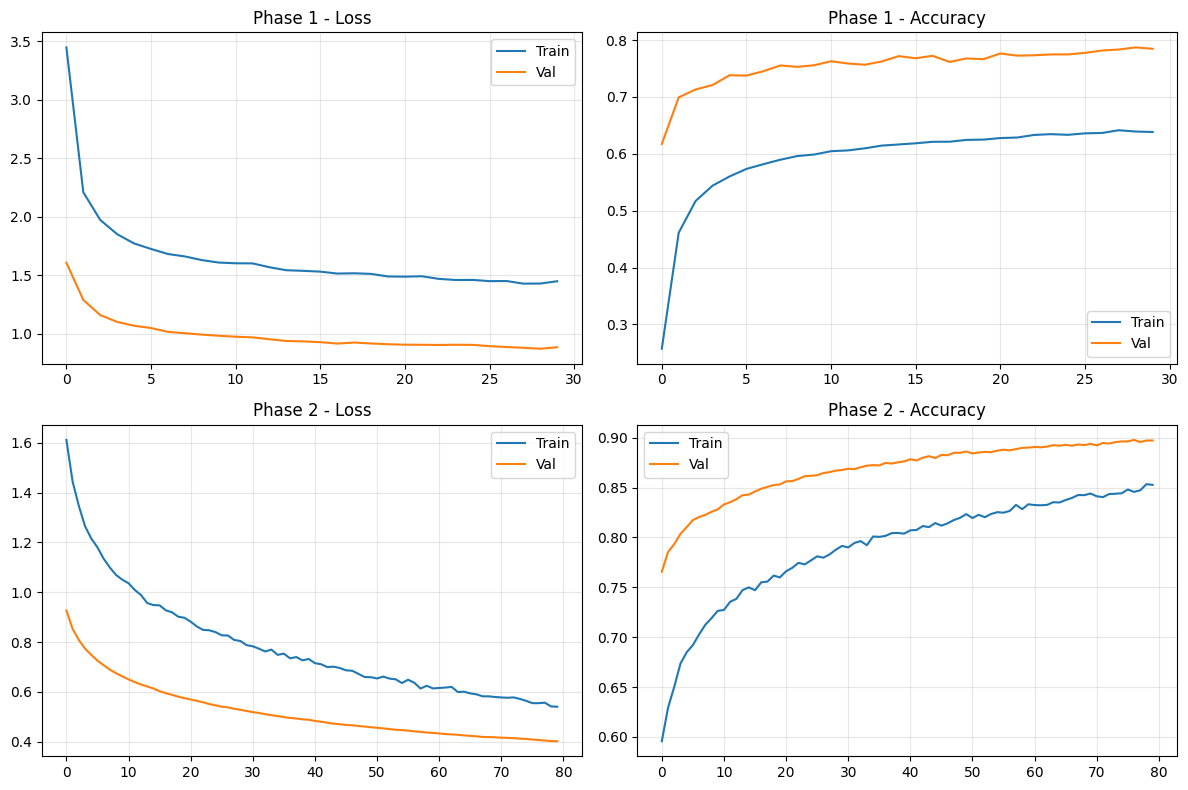

Phase 1: 0.7872 | Phase 2: 0.8978 | Gain: +11.06%


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Phase 1
axes[0, 0].plot(history_p1.history['loss'], label='Train')
axes[0, 0].plot(history_p1.history['val_loss'], label='Val')
axes[0, 0].set_title('Phase 1 - Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_p1.history['accuracy'], label='Train')
axes[0, 1].plot(history_p1.history['val_accuracy'], label='Val')
axes[0, 1].set_title('Phase 1 - Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Phase 2
axes[1, 0].plot(history_p2.history['loss'], label='Train')
axes[1, 0].plot(history_p2.history['val_loss'], label='Val')
axes[1, 0].set_title('Phase 2 - Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history_p2.history['accuracy'], label='Train')
axes[1, 1].plot(history_p2.history['val_accuracy'], label='Val')
axes[1, 1].set_title('Phase 2 - Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

p1_best = max(history_p1.history['val_accuracy'])
p2_best = max(history_p2.history['val_accuracy'])
print(f"Phase 1: {p1_best:.4f} | Phase 2: {p2_best:.4f} | Gain: +{(p2_best-p1_best)*100:.2f}%")

## Sauvegarde

In [9]:
model.save('pokemon_classifier_efficientnet.keras')
print(f"Modèle sauvegardé: pokemon_classifier_efficientnet.keras")
print(f"Taille: {Path('pokemon_classifier_efficientnet.keras').stat().st_size / (1024*1024):.1f} MB")

Modèle sauvegardé: pokemon_classifier_efficientnet.keras
Taille: 37.2 MB


## Évaluation sur le Test Set

In [10]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9049 - loss: 0.3647

Test Accuracy: 0.9049 (90.49%)
Test Loss: 0.3647


## Matrice de confusion - Top 20 classes

102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step


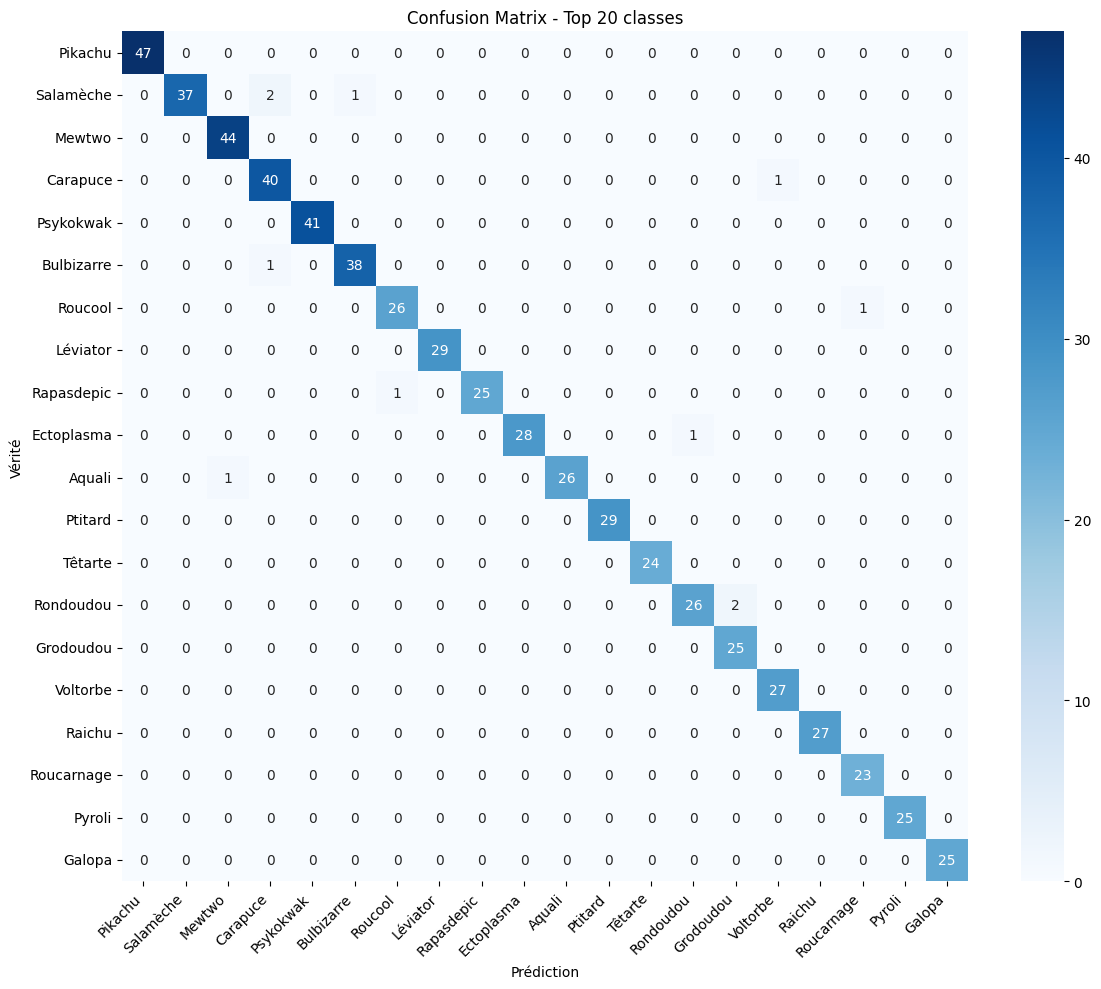

In [11]:
y_pred_proba = model.predict(test_dataset)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(test_labels_onehot, axis=1)

top_20_classes = pd.Series(y_true).value_counts().head(20).index.tolist()
top_20_names = [list(label_to_idx.keys())[i] for i in top_20_classes]

mask = np.isin(y_true, top_20_classes)
cm = confusion_matrix(y_true[mask], y_pred[mask], labels=top_20_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=top_20_names, yticklabels=top_20_names)
plt.title('Confusion Matrix - Top 20 classes')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Matrice de confusion - Worst 20 classes

Classes avec le plus d'erreurs de classification.

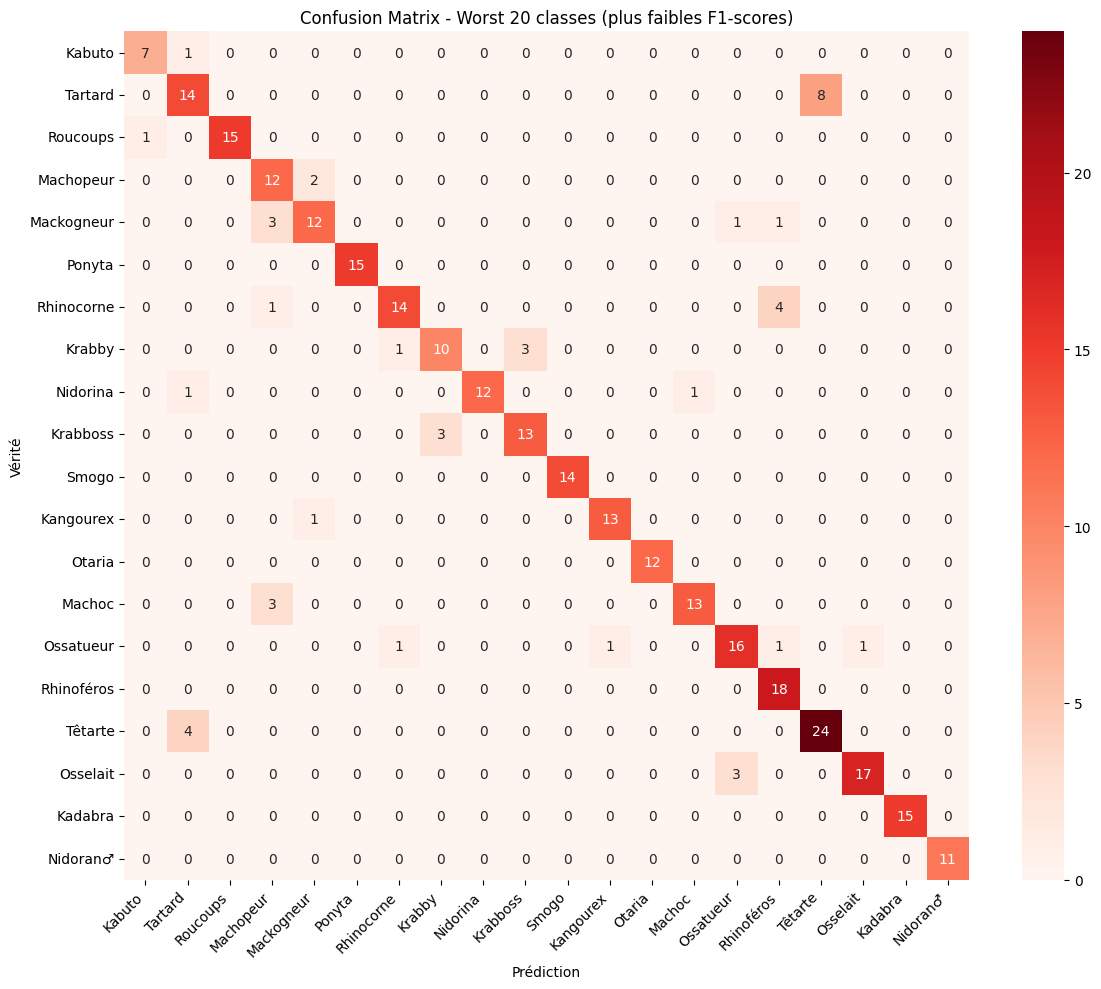

Classes avec les plus faibles performances:
  Kabuto: F1=0.636
  Tartard: F1=0.651
  Roucoups: F1=0.667
  Machopeur: F1=0.686
  Mackogneur: F1=0.686
  Ponyta: F1=0.698
  Rhinocorne: F1=0.700
  Krabby: F1=0.714
  Nidorina: F1=0.727
  Krabboss: F1=0.743


In [12]:
report = classification_report(y_true, y_pred, target_names=list(label_to_idx.keys()), 
                               output_dict=True, zero_division=0)

class_f1 = {name: report[name]['f1-score'] for name in label_to_idx.keys()}
worst_20_names = sorted(class_f1, key=class_f1.get)[:20]
worst_20_classes = [label_to_idx[name] for name in worst_20_names]

mask_worst = np.isin(y_true, worst_20_classes)
cm_worst = confusion_matrix(y_true[mask_worst], y_pred[mask_worst], labels=worst_20_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_worst, annot=True, fmt='d', cmap='Reds', 
            xticklabels=worst_20_names, yticklabels=worst_20_names)
plt.title('Confusion Matrix - Worst 20 classes (plus faibles F1-scores)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Classes avec les plus faibles performances:")
for name in worst_20_names[:10]:
    print(f"  {name}: F1={class_f1[name]:.3f}")

## Métriques globales

In [13]:
print(f"Accuracy:  {report['accuracy']:.4f}")
print(f"Precision: {report['macro avg']['precision']:.4f}")
print(f"Recall:    {report['macro avg']['recall']:.4f}")
print(f"F1-Score:  {report['macro avg']['f1-score']:.4f}")

Accuracy:  0.9049
Precision: 0.9043
Recall:    0.9014
F1-Score:  0.9006


## Visualisation des prédictions

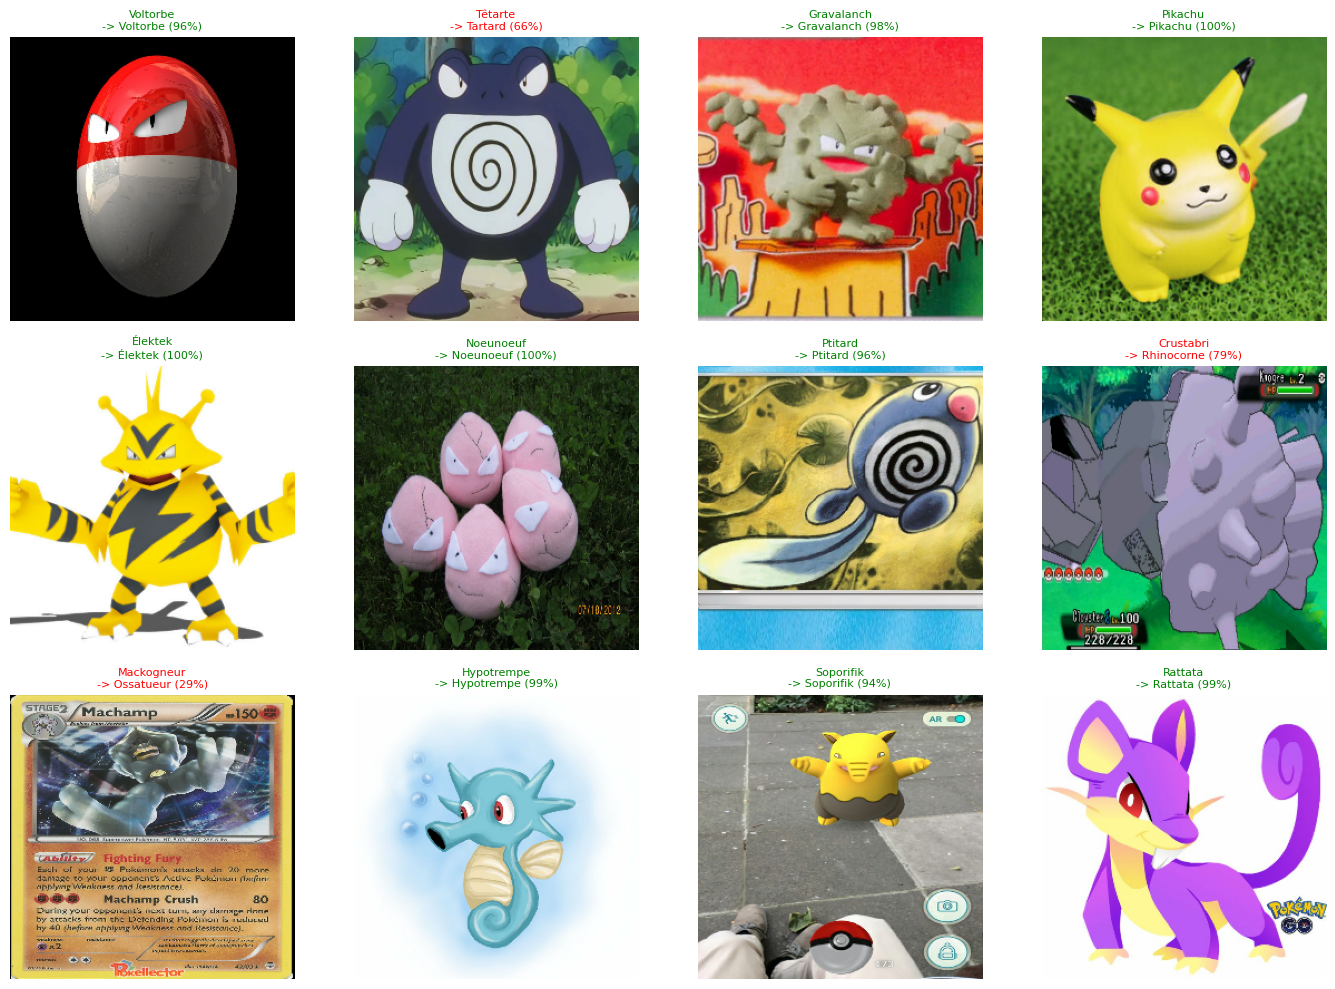

In [14]:
np.random.seed(42)
random_indices = np.random.choice(len(test_paths), 12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(14, 10))

for idx, test_idx in enumerate(random_indices):
    img = tf.io.read_file(test_paths[test_idx])
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img_resized = tf.image.resize(img, (256, 256))
    
    prediction = model.predict(tf.expand_dims(preprocess_input(img_resized), 0), verbose=0)
    predicted_class = list(label_to_idx.keys())[np.argmax(prediction[0])]
    confidence = np.max(prediction[0])
    true_class = test_labels[test_idx]
    
    axes.flat[idx].imshow(img_resized.numpy().astype('uint8'))
    color = 'green' if predicted_class == true_class else 'red'
    axes.flat[idx].set_title(f"{true_class}\n-> {predicted_class} ({confidence*100:.0f}%)", 
                              fontsize=8, color=color)
    axes.flat[idx].axis('off')

plt.tight_layout()
plt.show()

## Test sur images externes

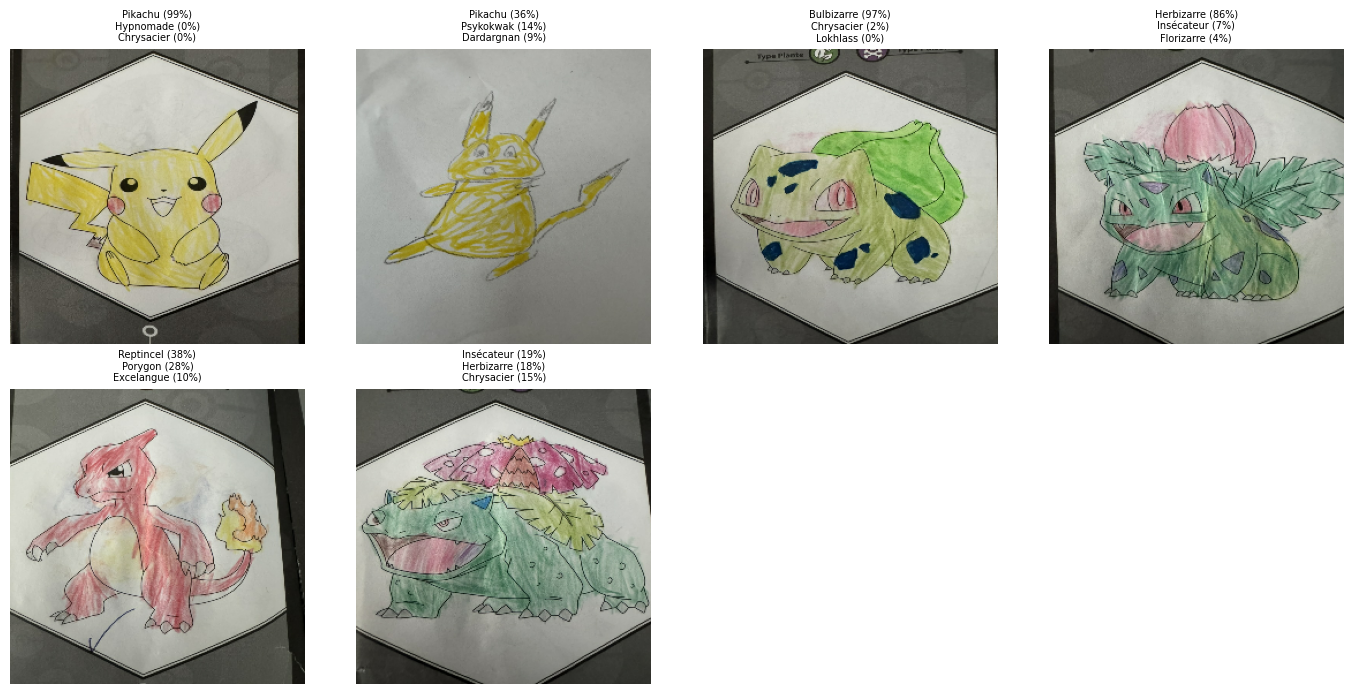

In [15]:
external_dir = Path('./Test_Img_Externes')

if external_dir.exists():
    external_images = [f for f in external_dir.iterdir() 
                       if f.suffix.lower() in image_extensions]
    
    if external_images:
        num_images = min(len(external_images), 8)
        fig, axes = plt.subplots(2, 4, figsize=(14, 7))
        
        for idx, img_path in enumerate(external_images[:num_images]):
            img = tf.io.read_file(str(img_path))
            img = tf.image.decode_image(img, channels=3, expand_animations=False)
            img_resized = tf.image.resize(img, (256, 256))
            
            prediction = model.predict(tf.expand_dims(preprocess_input(img_resized), 0), verbose=0)
            top3_idx = np.argsort(prediction[0])[-3:][::-1]
            
            axes.flat[idx].imshow(img_resized.numpy().astype('uint8'))
            title = "\n".join([f"{list(label_to_idx.keys())[i]} ({prediction[0][i]*100:.0f}%)" 
                               for i in top3_idx])
            axes.flat[idx].set_title(title, fontsize=7)
            axes.flat[idx].axis('off')
        
        for idx in range(num_images, 8):
            axes.flat[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print(f"Répertoire {external_dir} non trouvé")